# **Solar Irradiance Prediction**

These datasets consist of meteorological observations collected at the HI-SEAS weather station over a four-month period from September to December 2016, during the interval between Mission IV and Mission V.

Each dataset is structured as follows:

- A sequential row number (1-n) for ordering this dataset's records
- The UNIX time_t value (seconds since January 1, 1970), which aids in aligning this dataset with others
- The date in the format of yyyy-mm-dd
- The local time in hh:mm:ss format, using a 24-hour clock
- Numeric data, which may sometimes be null
- Textual data, which can also be null

The datasets include measurements of various environmental parameters, each specified with its unit of measurement:

- **Solar radiation** is quantified in watts per square meter.
- **Temperature** values are reported in degrees Fahrenheit.
- **Humidity** is expressed as a percentage.
- **Barometric pressure** is measured in inches of mercury.
- **Wind direction** is provided in degrees.
- **Wind speed** is noted in miles per hour.
- **Sunrise and sunset** times are specified in Hawaii local time.


In [ ]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from scipy import stats
import re

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

# !pip install xgboost
import xgboost as xgb

from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from collections import Counter

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## **Loading Solar Irradiance Dataset**

In [ ]:
data = pd.read_csv("sample_data/SolarPrediction.csv")

In [ ]:
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


## **Data Wrangling**

In [ ]:
df = data.copy()

In [ ]:
df['Data'] = df['Data'].apply(lambda x : x.split()[0])

In [ ]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


This below code snippet extracts the month, day, hour, minute, and second from the datetime columns 'Data' and 'Time' in the dataframe df, creating new columns for each unit of time.

In [ ]:
df['Month'] = pd.to_datetime(df['Data']).dt.month
df['Day'] = pd.to_datetime(df['Data']).dt.day
df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Minute'] = pd.to_datetime(df['Time']).dt.minute
df['Second'] = pd.to_datetime(df['Time']).dt.second

In [ ]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24



The below code extracts the hour and minute components from the sunrise and sunset time columns ('TimeSunRise' and 'TimeSunSet') in the dataframe df. It uses regular expressions to identify and convert the hour and minute parts into integers, creating new columns for each ('risehour', 'riseminute', 'sethour', 'setminute') to represent these extracted times

In [ ]:
df['risehour'] = df['TimeSunRise'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['riseminuter'] = df['TimeSunRise'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

df['sethour'] = df['TimeSunSet'].apply(lambda x : re.search(r'^\d+', x).group(0)).astype(int)
df['setminute'] = df['TimeSunSet'].apply(lambda x : re.search(r'(?<=\:)\d+(?=\:)', x).group(0)).astype(int)

In [ ]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26,6,13,18,13
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23,6,13,18,13
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26,6,13,18,13
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21,6,13,18,13
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24,6,13,18,13


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
 11  Month                   32686 non-null  int64  
 12  Day                     32686 non-null  int64  
 13  Hour                    32686 non-null  int64  
 14  Minute                  32686 non-null

After extracting the necessary time components from the sunrise and sunset columns, remove the original columns to streamline the dataframe, keeping only the relevant derived data.

In [ ]:
df.drop(['UNIXTime', 'Data', 'Time', 'TimeSunRise', 'TimeSunSet'], axis = 1, inplace = True)

In [ ]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,1.21,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,1.21,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,1.23,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,1.21,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,1.17,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


Lets now check the dimensions of the dataframe df, indicating the total number of rows and columns it contains

In [ ]:
df.shape

(32686, 15)

Lets quickly check whether we have null values present

In [ ]:
df.isnull().sum().sum()

0

In [ ]:
# Convert the 'Radiation' column to a numpy array for further analysis or model input.
y = np.array(df['Radiation'])

In [ ]:
y

array([1.21, 1.21, 1.23, ..., 1.2 , 1.23, 1.2 ])

In [ ]:
# Display the shape of the array 'y' to check its dimensionality, typically the number of samples.
y.shape

(32686,)

In [ ]:
# Create a set of input features by removing the 'Radiation' column from the dataframe, which is our target variable.
input_features = df.drop('Radiation', axis = 1)

# Isolate the 'Radiation' column as the target variable for predictive modeling.
target = df['Radiation']

# **Feature Selection**

In [ ]:
df.corr()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627,-0.095450,0.039978,0.004398,-0.000730,-0.031270,NaN,-0.092850,0.048719,-0.039816
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458,-0.354560,-0.123705,0.197464,-0.001934,-0.036147,NaN,-0.380968,0.300920,-0.242881
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639,-0.341759,-0.024633,0.091069,0.001860,-0.031102,NaN,-0.380399,0.151939,-0.119599
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624,-0.068854,0.014637,0.077899,0.000499,-0.027682,NaN,-0.023955,0.145143,-0.119526
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092,0.181485,-0.082354,-0.077969,-0.000602,-0.032568,NaN,0.176929,-0.078540,0.070030
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000,0.150822,0.117337,-0.057939,0.000192,-0.032934,NaN,0.167075,-0.159384,0.119926
Month,-0.095450,-0.354560,-0.341759,-0.068854,0.181485,0.150822,1.000000,0.038027,-0.005396,0.000168,0.220563,NaN,0.952472,-0.784783,0.541883
Day,0.039978,-0.123705,-0.024633,0.014637,-0.082354,0.117337,0.038027,1.000000,-0.008010,-0.000196,0.089078,NaN,0.274522,-0.263575,0.265662
Hour,0.004398,0.197464,0.091069,0.077899,-0.077969,-0.057939,-0.005396,-0.008010,1.000000,-0.004052,0.004199,NaN,-0.006772,0.008629,-0.007056
Minute,-0.000730,-0.001934,0.001860,0.000499,-0.000602,0.000192,0.000168,-0.000196,-0.004052,1.000000,0.002517,NaN,-0.000158,0.001052,-0.002215


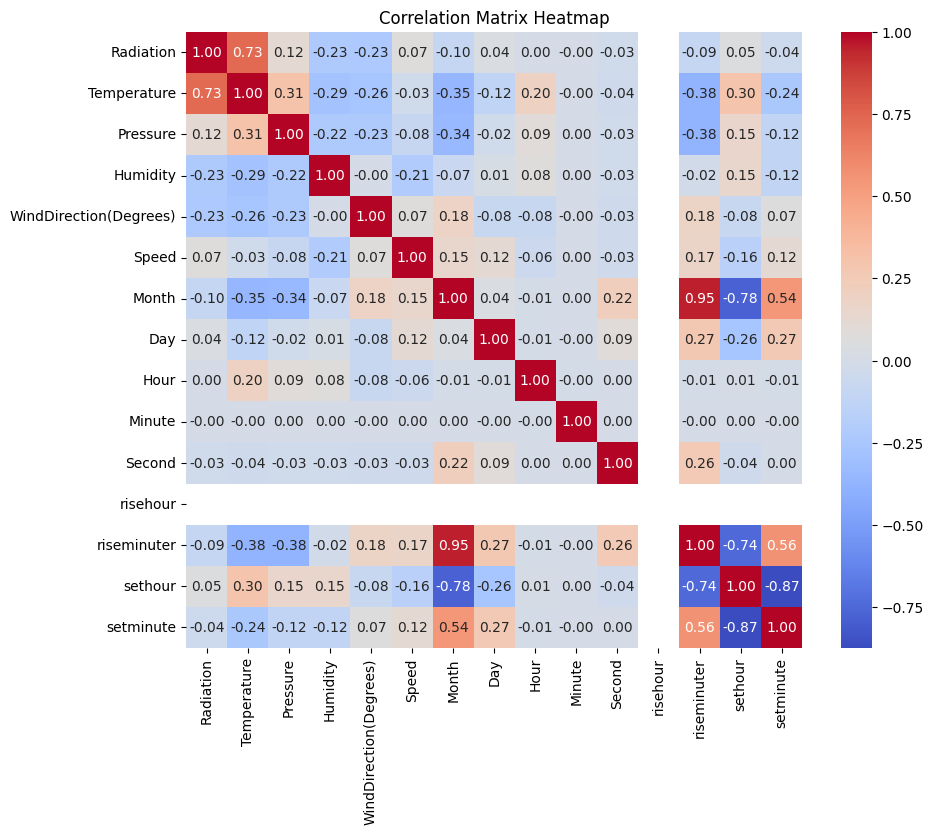

In [ ]:
# Calculate the correlation matrix
corr = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

we observe several interesting relationships between different meteorological parameters and the components extracted from the time of solar irradiance data. Notably, there's a strong positive correlation between **Radiation** and **Temperature** (0.734955), indicating that as temperature increases, so does the solar radiation. Conversely, **Humidity** shows a negative correlation with **Radiation** (-0.226171), suggesting higher humidity levels may be associated with lower solar radiation.

The correlations between Radiation and the time components (Month, Day, Hour, Minute, Second) are generally weak, indicating that these time factors alone may not strongly predict solar radiation levels.

Moreover, the correlations between Month and other time-based components like riseminuter (0.952472) and sethour (-0.784783) highlight a strong seasonal influence on sunrise and sunset times, which is expected. The negative correlation between Temperature and Month (-0.354560) also underscores the seasonal variation in temperature.

## **Feature Selection using SelectKBest Method**

The below code snippet initiates an instance of the SelectKBest class from scikit-learn, using the **chi2** score function to select the top 10 features. SelectKBest is a feature selection method that selects features according to the highest scores from a statistical test, in this case, the chi-squared (χ²) statistical test. The **chi2** function evaluates the independence between each feature and the target variable, with higher scores indicating features that are more likely to have a strong relationship with the target variable. This technique is particularly useful for reducing the dimensionality of a dataset, enhancing model performance, and possibly improving computation efficiency

In [ ]:
bestfeatures = SelectKBest(score_func = chi2, k = 10)

To prepare the continuous float values of our target variable for use with `SelectKBest` and its `chi2` test, which requires categorical labels, two transformation strategies can be implemented:

1. **Utilizing `LabelEncoder`**: This technique leverages the `LabelEncoder` from scikit-learn to convert floating-point numbers into a series of integer labels. This conversion assigns a unique integer to each distinct float value, effectively categorizing the continuous data.

2. **Scaling and Converting to Integers**: Alternatively, the data can be scaled by multiplying all float values by 100 and then casting these scaled values to integers. This approach transforms the continuous numerical data into integer labels, making them suitable for categorical analysis by the model.

By adopting either of these methods, we transform the dataset in a way that allows `SelectKBest` to perform feature selection using the chi-squared statistical test effectively.


In [ ]:
# Import the preprocessing module from scikit-learn
from sklearn import preprocessing

# Initialize the LabelEncoder
label_encoder = preprocessing.LabelEncoder()

# Transform the 'target' column of continuous float values into integer labels
# This is achieved by fitting the LabelEncoder to the target data and then transforming it,
# which assigns a unique integer to each unique value in the target.
train_Y = label_encoder.fit_transform(target)


This code first adjusts the 'Radiation' target values into an integer format suitable for chi-squared tests by multiplying each value by 100 and converting to an integer. Then, it normalizes the input features using **MinMaxScaler**, which is crucial for maintaining consistency across different scales. Finally, SelectKBest is applied to the normalized features and the transformed target, selecting the features most correlated with the target based on chi-squared statistics

In [ ]:
# Scale the 'Radiation' target variable by multiplying by 100 and converting to integer
# This approach effectively transforms the continuous float values into discrete integer labels
target_cont = df['Radiation'].apply(lambda x: int(x*100))

# Scale the input features using MinMaxScaler for normalization
# MinMaxScaler transforms features by scaling each feature to a given range, here [0, 1]
scaled_input_features = MinMaxScaler().fit_transform(input_features)

# Fit the SelectKBest feature selection method to the scaled input features and transformed target
# This step selects the top k features that have the highest chi-squared statistics with respect to the target
fit = bestfeatures.fit(scaled_input_features, target_cont)


In [ ]:
# Create a DataFrame to hold the scores from the feature selection.This provides an easy-to-read table of scores for each feature
scores = pd.DataFrame(fit.scores_)
# Create a DataFrame for the column names of the input features.This helps in identifying the features by name alongside their scores
column = pd.DataFrame(input_features.columns)

In [ ]:
# Concatenate the feature names with their corresponding scores into a single DataFrame. This combination allows for a side-by-side comparison of each feature with its importance score
featureScores = pd.concat([column, scores], axis=1)

# Assign column names to the DataFrame for clarity
# 'Features' column will list the name of each feature, and 'feature_imp' column will show the corresponding feature importance score
featureScores.columns = ['Features', 'feature_imp']


In [ ]:
featureScores.sort_values(by = 'feature_imp', ascending=False, inplace=True)
featureScores

,Features,feature_imp
12,sethour,12207.531454
5,Month,4684.579610
11,riseminuter,4015.062771
3,WindDirection(Degrees),3271.827277
6,Day,2841.926850
8,Minute,2702.449333
9,Second,2288.673032
13,setminute,1863.712087
0,Temperature,1651.685632
2,Humidity,1588.087433


The output DataFrame prioritizes features based on their importance scores derived from the `SelectKBest` method using chi-squared statistics. Here's a breakdown of the results:

- **sethour**: The top-ranked feature with an importance score of 12207.531454, representing the sunset hour, is the most influential in predicting the target variable.
- **Month**: This feature has a significant score of 4684.579610, underscoring its strong relevance in the analysis.
- **riseminuter**: Indicating the minute of sunrise, this feature's importance score of 4015.062771 highlights its critical role in predictions.
- **WindDirection(Degrees)**: With a score of 3271.827277, it underscores the importance of wind direction in the model.
- **Day, Minute, Second, setminute**: These temporal features exhibit considerable importance scores, demonstrating their predictive utility for the target variable.
- **Temperature** and **Humidity**: These physical measurements receive scores of 1651.685632 and 1588.087433, respectively, marking them as relatively influential.
- **Speed** and **Hour**: Despite their lower scores, these features are deemed relevant to the analysis.
- **Pressure**: With the lowest numeric feature score of 523.791060, it appears to have the least impact on the target variable among the listed features.
- **risehour**: This feature is noted with a 'NaN' score, suggesting it may have been non-variant or constant throughout the dataset, resulting in an undefined score.

This prioritized listing provides insight into which features most significantly influence the target variable, informing the selection of features for model optimization and predictive accuracy enhancement.


Text(0.5, 0, 'Importance')

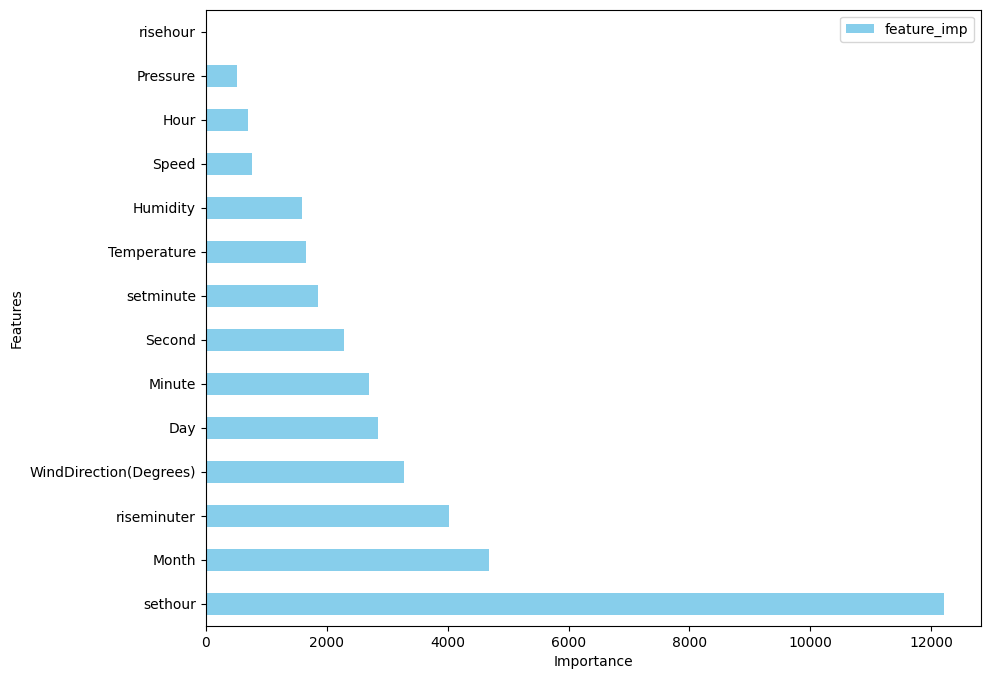

In [ ]:
featureScores.plot('Features', 'feature_imp', kind='barh', figsize=(10, 8), color='skyblue').set_xlabel('Importance')


## **Feature Engineering with BoxCox, Log, Min-Max and Standard transformation**

1. **Looping Over Features**: The code iterates over the list of features to transform, which includes 'Temperature', 'Pressure', 'Humidity', 'Speed', and 'WindDirection(Degrees)'.

2. **Subplot Creation**: For each feature, a subplot grid is created using `plt.subplots()` with 3 rows and 2 columns to accommodate the histograms for the original data and four transformation methods.

3. **Histogram Plots**: Histograms are plotted for each transformation method alongside the original data. The transformations include:
   - **Log Transformation**: Applied using `np.log()`.
   - **Box-Cox Transformation**: Utilized through `stats.boxcox()` method.
   - **Standard Scaling**: Standardization using `StandardScaler()` from scikit-learn.
   - **Min-Max Scaling**: Normalization using `MinMaxScaler()` from scikit-learn.

4. **Titles and Labels**: Titles are set for each subplot to indicate the transformation method applied. Additionally, labels are set for the y-axis to denote the type of transformation.

5. **Displaying Plots**: Finally, the `plt.tight_layout()` function ensures proper spacing between subplots, and `plt.show()` displays the generated plots.

Overall, this code provides a visual comparison of different feature transformation methods, helping in understanding their effects on the distribution of data.

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


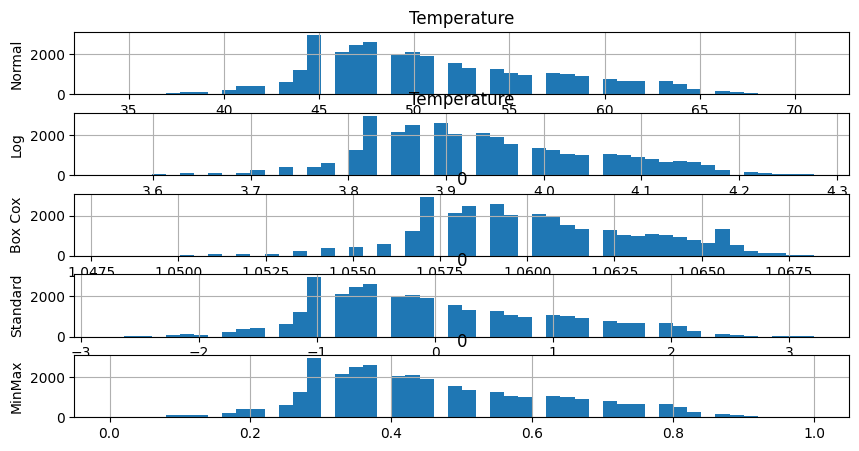

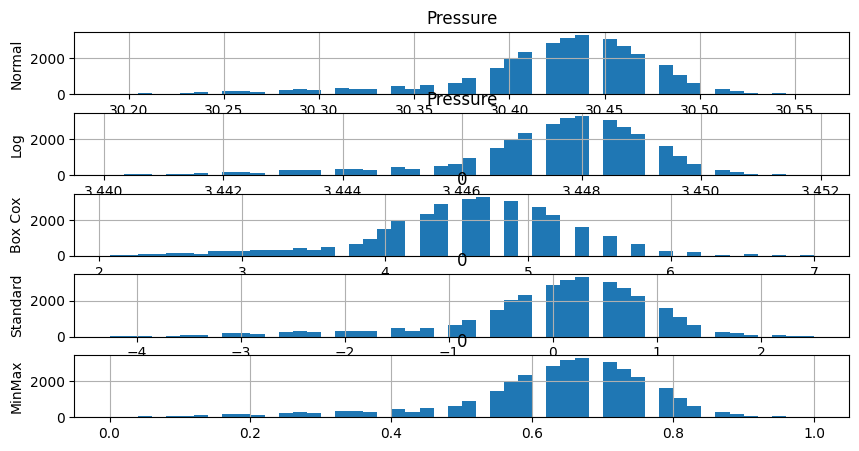

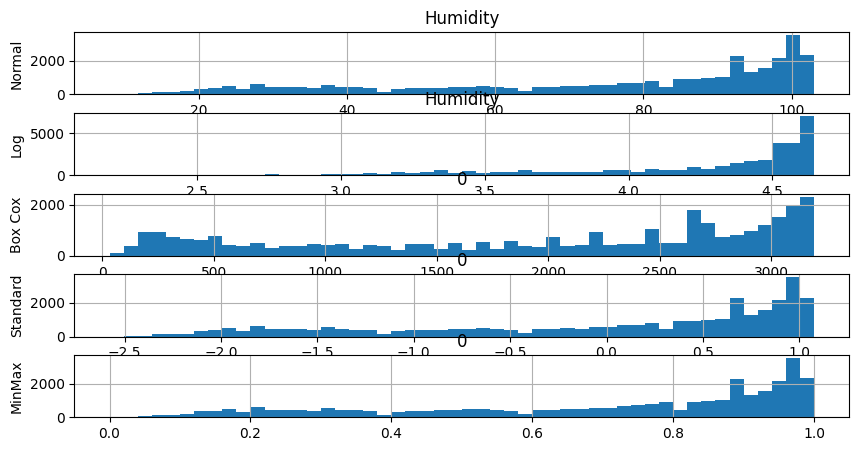

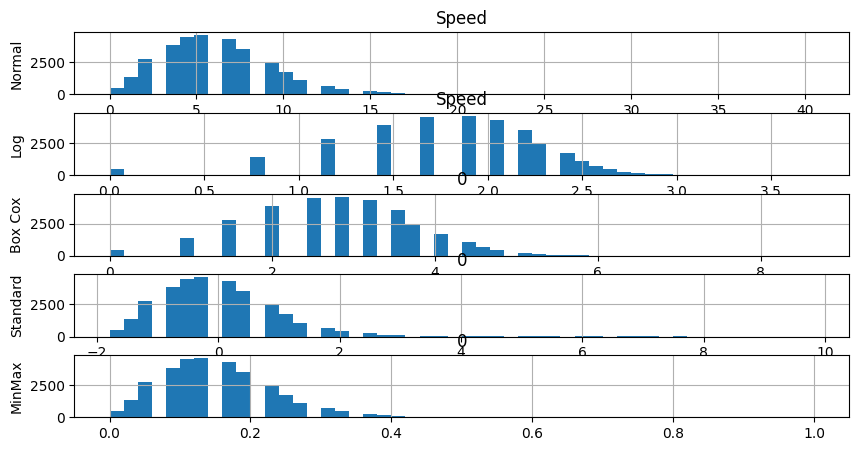

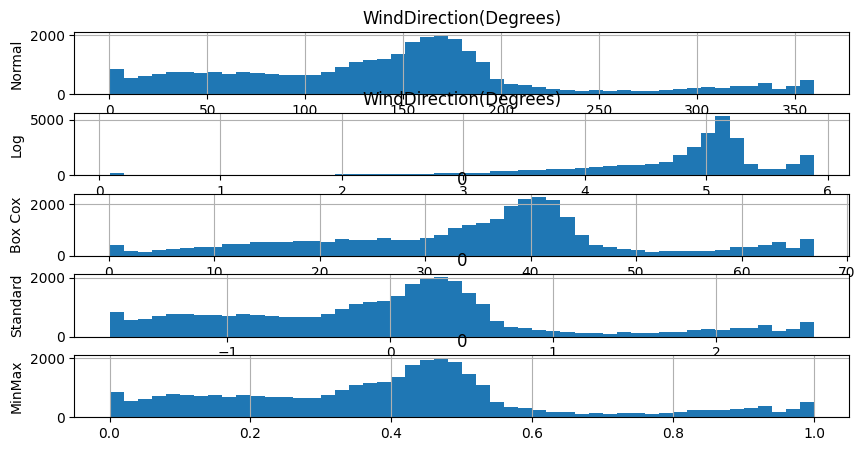

In [ ]:
features_to_transform = ['Temperature', 'Pressure', 'Humidity', 'Speed', 'WindDirection(Degrees)']

for i in features_to_transform:

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 5))

    pd.DataFrame(input_features[i]).hist(ax = ax1, bins = 50)
    pd.DataFrame((input_features[i]+1).transform(np.log)).hist(ax = ax2, bins = 50)
    pd.DataFrame(stats.boxcox(input_features[i]+1)[0]).hist(ax = ax3, bins = 50)
    pd.DataFrame(StandardScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax4, bins = 50)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(input_features[i]).reshape(-1, 1))).hist(ax = ax5, bins = 50)

    ax1.set_ylabel('Normal')
    ax2.set_ylabel('Log')
    ax3.set_ylabel('Box Cox')
    ax4.set_ylabel('Standard')
    ax5.set_ylabel('MinMax')

The below code initializes a dictionary named transform where the keys represent feature names ('Temperature', 'Pressure', 'Humidity', 'Speed', 'WindDirection(Degrees)'), and the values represent the transformed versions of these features.


**Performing Transformations:**

For the 'Temperature' feature, it applies a log transformation to the original feature values after adding 1 to avoid logarithm of zero or negative values.
For the 'Pressure' and 'Humidity' features, it applies the Box-Cox transformation using stats.boxcox() after adding 1 to avoid zero values.
For the 'Speed' feature, it applies a log transformation to the original feature values after adding 1 to avoid logarithm of zero or negative values.
For the 'WindDirection(Degrees)' feature, it applies min-max scaling using MinMaxScaler() from scikit-learn to scale the values between 0 and 1.
Updating Input Features:

It iterates over the keys of the transform dictionary.
For each key, it updates the corresponding feature in the input_features dataset with its transformed values.

In [ ]:
transform = {'Temperature' : (input_features['Temperature']+1).transform(np.log),
             'Pressure': stats.boxcox(input_features['Pressure']+1)[0],
            'Humidity' : stats.boxcox(input_features['Humidity']+1)[0],
            'Speed' : (input_features['Speed']+1).transform(np.log),
            'WindDirection(Degrees)' : MinMaxScaler().fit_transform(
                np.array(input_features['WindDirection(Degrees)']).reshape(-1, 1))}

for i in transform:
    input_features[i] = transform[i]

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:187: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [ ]:
input_features.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,risehour,riseminuter,sethour,setminute
0,3.89182,5.044903e+152,1139.358665,0.492692,1.890095,9,29,23,55,26,6,13,18,13
1,3.89182,5.044903e+152,1104.046980,0.490996,1.474763,9,29,23,50,23,6,13,18,13
2,3.89182,5.044903e+152,1069.253545,0.440894,1.474763,9,29,23,45,26,6,13,18,13
3,3.89182,5.044903e+152,1175.187489,0.382426,1.474763,9,29,23,40,21,6,13,18,13
4,3.89182,5.044903e+152,1248.392213,0.291391,1.890095,9,29,23,35,24,6,13,18,13


# **Data Preparation**

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(input_features, target, test_size=0.2, random_state=1)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [ ]:
xtrain.shape, xtest.shape

((26148, 14), (6538, 14))

# **Prediction with XGBoost**

### Initialization of XGBoost Regression Model

#### Hyperparameter Definition:
The `params` dictionary contains hyperparameters for the XGBoost regression model. In this case, it defines:

- `'learning_rate'`: The step size shrinkage used to prevent overfitting. A lower value makes the model more robust by shrinking the weights on each step.
- `'max_depth'`: The maximum depth of a tree. It controls the complexity of the trees built by the model.

#### Model Initialization:
- Import the `XGBRegressor` class from the `xgboost` library.
- Initialize the `model` with the specified hyperparameters using `**params` to unpack the dictionary and pass the values as arguments to the model constructor.

```python
params = {
    'learning_rate': 0.1,
    'max_depth': 8
}

from xgboost import XGBRegressor
model = XGBRegressor(**params)


In [ ]:
params = {
    'learning_rate': 0.1,
    'max_depth': 8}

from xgboost import XGBRegressor
model = XGBRegressor(**params)

In [ ]:
model.fit(xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = model.predict(xtest)

In [ ]:
print(f'XGBoost model result: {np.sqrt(mean_squared_error(ytest, y_pred)):.4f}')


XGBoost model result: 81.8749


In [ ]:
rmse = np.sqrt(mean_squared_error(ytest, y_pred))
r2 = r2_score(ytest, y_pred)


print("Testing performance")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")


Testing performance
RMSE: 81.87
R2: 0.93


# **MultiLayer Perceptron for prediction**

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(input_features, target, test_size=0.2, random_state=1)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

### Neural Network Regression Model Definition

#### Model Initialization:
- `model = Sequential()`: Initializes a sequential model. This model type allows for the creation of deep learning models layer by layer.

#### Adding Layers:
- `model.add(Dense(128, activation='relu', input_dim=14))`: Adds a dense layer with 128 neurons, using the ReLU activation function. It also specifies an input dimension of 14, indicating the number of input features.
- `model.add(Dropout(0.33))`: Adds a dropout layer with a dropout rate of 0.33. Dropout is a regularization technique used to prevent overfitting by randomly setting a fraction of input units to zero during training.
- `model.add(Dense(64, activation='relu'))`: Adds another dense layer with 64 neurons and ReLU activation.
- `model.add(Dropout(0.33))`: Adds another dropout layer.
- `model.add(Dense(32, activation='relu'))`: Adds another dense layer with 32 neurons and ReLU activation.
- `model.add(Dropout(0.33))`: Adds another dropout layer.

#### Output Layer:
- `model.add(Dense(1, activation='linear'))`: Adds the output layer with a single neuron for regression, using a linear activation function since it's a regression problem.

#### Compiling the Model:
- `model.compile(metrics='mse', loss='mae', optimizer=Adam(learning_rate=0.001))`: Compiles the model. It specifies Mean Squared Error (MSE) as the evaluation metric, Mean Absolute Error (MAE) as the loss function, and the Adam optimizer with a learning rate of 0.001.

#### Summary:
- `print(model.summary())`: Prints a summary of the model architecture, including the number of parameters in each layer and the total number of trainable parameters.


In [ ]:
model = None
model = Sequential()

model.add(Dense(128, activation='relu', input_dim=14))
model.add(Dropout(0.33))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(1, activation='linear'))

model.compile(metrics='mse', loss='mae', optimizer=Adam(learning_rate=0.001))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1920      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

By calling model.**fit**(), the neural network model is trained on the provided training data (xtrain and ytrain). During training, the model adjusts its weights based on the input data to minimize the specified loss function (Mean Absolute Error in this case). The training process continues for the specified number of epochs, with the provided batch size.

Additionally, validation data is used to monitor the model's performance on unseen data and prevent overfitting. The training history, including loss and metrics values, is stored in the modelfitting variable.

In [ ]:

modelfitting = model.fit(xtrain, ytrain, validation_split=0.1, epochs=50, batch_size=32)

Epoch 1/50
736/736 [==============================] - 6s 4ms/step - loss: 121.0099 - mse: 55429.3906 - val_loss: 78.8097 - val_mse: 23538.0723
Epoch 2/50
736/736 [==============================] - 2s 3ms/step - loss: 85.2136 - mse: 27258.7383 - val_loss: 70.4165 - val_mse: 19179.7383
Epoch 3/50
736/736 [==============================] - 3s 4ms/step - loss: 80.7647 - mse: 24642.1133 - val_loss: 65.5240 - val_mse: 16360.1084
Epoch 4/50
736/736 [==============================] - 2s 3ms/step - loss: 77.0220 - mse: 22606.1504 - val_loss: 61.1548 - val_mse: 14862.7656
Epoch 5/50
736/736 [==============================] - 2s 3ms/step - loss: 75.5090 - mse: 22275.8398 - val_loss: 60.9797 - val_mse: 14871.9912
Epoch 6/50
736/736 [==============================] - 2s 2ms/step - loss: 72.9153 - mse: 20683.2695 - val_loss: 57.1434 - val_mse: 13746.7549
Epoch 7/50
736/736 [==============================] - 2s 2ms/step - loss: 70.3426 - mse: 19519.0703 - val_loss: 54.7069 - val_mse: 12487.8496
Epoch

The returned scores are stored in the scores variable.

mae = scores[0]: Extracts the Mean Absolute Error (MAE) from the scores array and assigns it to the variable mae.

mse = scores[1]: Extracts the Mean Squared Error (MSE) from the scores array and assigns it to the variable mse.

In [ ]:
scores = model.evaluate(xtest, ytest)
mae = scores[0]
mse = scores[1]
print('Mean absolute error: ', mae)

205/205 [==============================] - 0s 2ms/step - loss: 42.0695 - mse: 9740.4541
Mean absolute error:  42.06945037841797
